In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import itertools
import warnings
import pickle
import joblib
import gzip

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

In [2]:
#Set some global plot defaults
sns.set(rc={"figure.figsize": (10, 8), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes',  labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes',  titlesize=18)                                  # fontsize of the title

In [3]:
#read it in
with gzip.GzipFile('data/cleaned_df.pkl.gz', 'r') as file:  
    df = joblib.load(file)

# 1. Cleaned DF

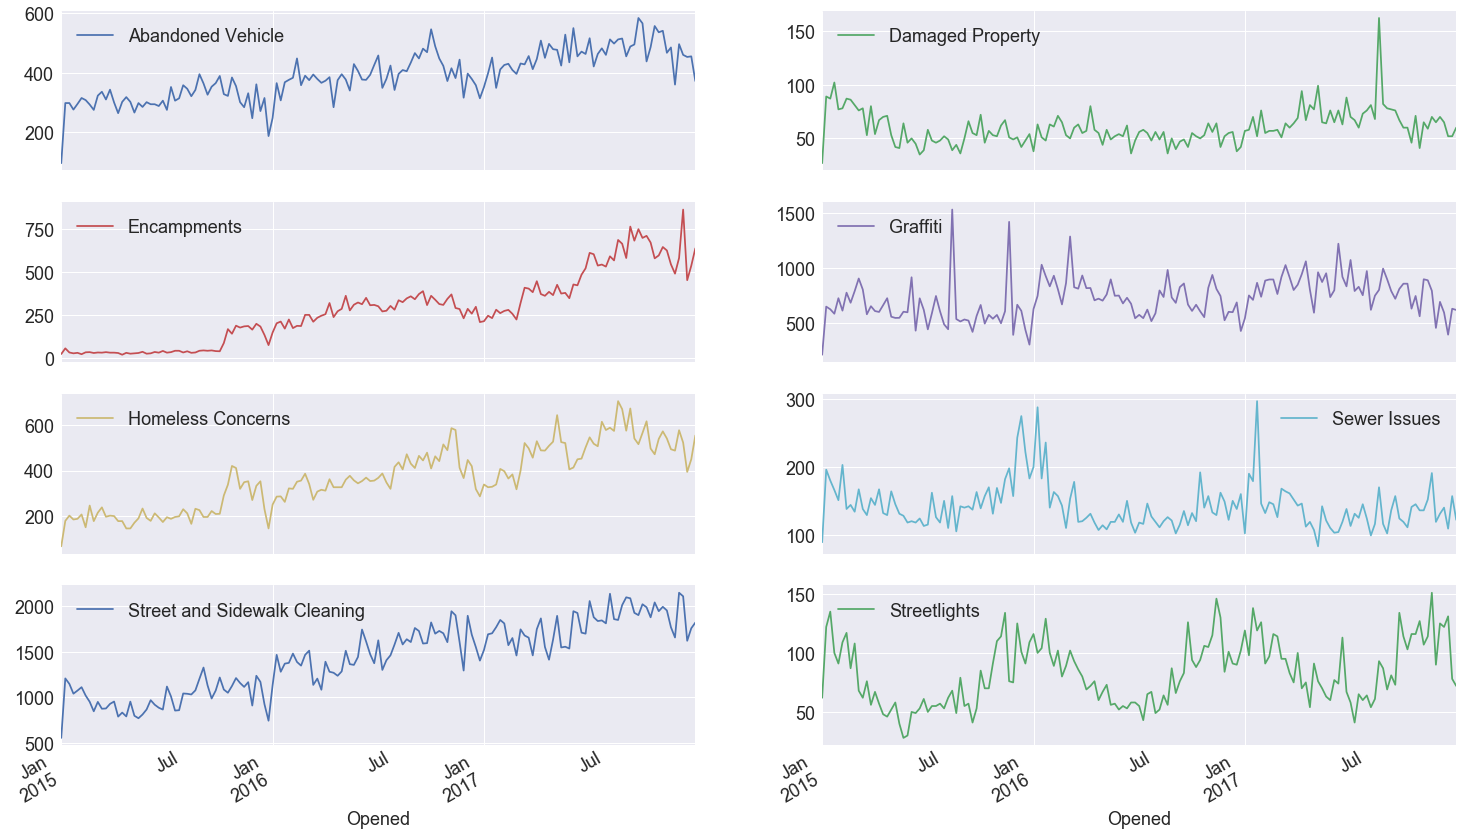

In [4]:
ts = df.copy()
ts = ts[['Opened', 'Category']]
ts.set_index('Opened', inplace=True)
ts = pd.get_dummies(ts['Category'])

ts.resample('W').sum().plot(subplots=True, figsize=(25, 15), layout=(4, 2), sharey=False)
plt.show()

## Optimize ARIMA params

In [5]:
d = range(0, 2)
p = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q)) if x[0] + x[1] + x[2] != 0 ]
seasonal_pdq = [(1,0,0,12), (0,1,0,12), (0,0,1,12), (1,1,0,12), (0,1,1,12)]

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [7]:
#Function that does the actual hyperparamter tuning
def param_search(params, params_sea, endog_data, exog_data=None):
    
    best_param = best_param_seasonal = ()
    best_aic = np.inf
    
    print '\tFinding the best fit over %i parameters... ' % (len(params_sea)*len(params)),
    start = time.time()
    for pdq in params:
        for pdq_sea in seasonal_pdq:
            try:    
                mod = sm.tsa.statespace.SARIMAX(endog=endog_data,
                                                exog=exog_data,
                                                order=pdq,
                                                seasonal_order=pdq_sea, #(1,0,0,12),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit(disp=False)

                if best_aic > results.aic:
                    best_aic = results.aic
                    best_param = pdq
                    best_param_seasonal = pdq_sea
                    
            except:
                continue
                
    #Print out the time it took        
    end = time.time()
    delta = end - start
    print(' and took %02d:%02d:%02d.' % (delta//3600., delta//60., delta%60.))      
    print('\tBest model is ARIMA{}x{} with AIC: {:.3f}'.format(best_param, best_param_seasonal, best_aic))
 
    return([best_param, best_param_seasonal, best_aic])

#Function to get the score of the model
def score_model(model, endog_data, exog_data=None,  
                start_date=pd.to_datetime('2017-10-08'), end_date=pd.to_datetime('2017-12-31')):
    
    aic = model.aic
    pred = model.get_prediction(start=start_date, end=end_date, exog=exog_data, dynamic=True)
    mae = mean_absolute_error(pred.predicted_mean, endog_data) 
        
    return(aic)

## Time series model for request category/census tract with and without census variables (exog vars)
### Resampled per week

In [8]:
model_i = 0
model_results = pd.DataFrame(columns=['Category', 'Tract', 'AIC_exog', 'AIC_no_exog'])

#Re-scale some features
ts_test = df.copy()
ts_test.drop(['Supervisor_District', 'Police_District', 'Latitude', 'Longitude', 'Source', 'Has_Media_Link', 
                  'Is_Closed'], axis=1, inplace=True)

#Scale to percent
ts_test['Poverty'] = ts_test['Poverty']/100.
ts_test['Unemployment'] = ts_test['Unemployment']/100.
ts_test['Percent_Male'] = ts_test['Percent_Male']/100.

#Scale to 0-1
ts_test['Population'] = MaxAbsScaler().fit_transform(ts_test['Population'].values.reshape(-1,1)).reshape(1,-1)[0]
ts_test['Income'] = MaxAbsScaler().fit_transform(ts_test['Income'].values.reshape(-1,1)).reshape(1,-1)[0]


for feature in df.Category.value_counts().index:

    time_series = ts_test[ts_test.Category == feature].copy()
    time_series.drop('Category', axis=1, inplace=True)
    print(feature)
    
    for tract, group in time_series.groupby('Tract'):
        temp = group.set_index('Opened')['Tract'].resample('W').count().to_frame(name='Counts')

        #Keep only resampled time series with no missing weeks
        if len(temp)==157:
            for col in group.drop(['Opened'], axis=1).columns:
                temp[col] = [group[col].mean()]*len(temp)
        else:
            continue
            
        #Select only those with certain total request counts    
        if len(group) > 3000:
            print('-> \t%s' % tract)
        
            x_data = temp.drop(['Counts', 'Tract'], axis=1)
            y_data = temp.drop('Tract', axis=1)['Counts']
            x_train = x_data[:-12]
            y_train = y_data[:-12]
            x_test  = x_data[-12:]
            y_test  = y_data[-13:]
        
            #Tune for best parameters
            best_param, best_param_seasonal, best_aic = param_search(pdq, seasonal_pdq, y_train, x_train)
        
            #Forecast with exog (exog=census variables)
            mod = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, 
                                            order=best_param, seasonal_order=best_param_seasonal, 
                                            enforce_invertibility=False, enforce_stationarity=False)
            results = mod.fit(disp=False)
            aic_exog = score_model(results, y_test, x_test)
        
            #Forecast without exog
            mod = sm.tsa.statespace.SARIMAX(endog=y_train, order=best_param, seasonal_order=best_param_seasonal, 
                                            enforce_invertibility=False, enforce_stationarity=False)
            results = mod.fit(disp=False)
            aic_no_exog = score_model(results, y_test)
         
            #Save the results
            model_results.loc['%i' % model_i] = [feature, tract, aic_exog, aic_no_exog]
            model_i = model_i + 1

Street and Sidewalk Cleaning
-> 	106.0
	Finding the best fit over 40 parameters...   and took 00:00:21.
	Best model is ARIMA(0, 1, 1)x(0, 1, 1, 12) with AIC: 816.134
-> 	176.01
	Finding the best fit over 40 parameters...   and took 00:00:22.
	Best model is ARIMA(1, 1, 1)x(0, 1, 1, 12) with AIC: 912.032
-> 	177.0
	Finding the best fit over 40 parameters...   and took 00:00:23.
	Best model is ARIMA(1, 1, 1)x(0, 1, 1, 12) with AIC: 953.968
-> 	178.02
	Finding the best fit over 40 parameters...   and took 00:00:22.
	Best model is ARIMA(0, 1, 1)x(0, 1, 1, 12) with AIC: 951.947
-> 	201.0
	Finding the best fit over 40 parameters...   and took 00:00:22.
	Best model is ARIMA(1, 1, 1)x(0, 1, 1, 12) with AIC: 987.562
-> 	202.0
	Finding the best fit over 40 parameters...   and took 00:00:23.
	Best model is ARIMA(0, 1, 1)x(0, 1, 1, 12) with AIC: 848.494
-> 	208.0
	Finding the best fit over 40 parameters...   and took 00:00:23.
	Best model is ARIMA(0, 1, 1)x(0, 1, 1, 12) with AIC: 922.191
-> 	228.01

## Including census variables makes the model worse 

In [9]:
model_results['Census_better'] = model_results.AIC_exog < model_results.AIC_no_exog
model_results

,Category,Tract,AIC_exog,AIC_no_exog,Census_better
0,Street and Sidewalk Cleaning,106.00,816.133626,788.133626,False
1,Street and Sidewalk Cleaning,176.01,912.032080,884.032080,False
2,Street and Sidewalk Cleaning,177.00,953.967507,925.967507,False
3,Street and Sidewalk Cleaning,178.02,951.947489,923.947489,False
4,Street and Sidewalk Cleaning,201.00,987.561554,959.561554,False
5,Street and Sidewalk Cleaning,202.00,848.494055,820.494055,False
6,Street and Sidewalk Cleaning,208.00,922.191154,894.191154,False
7,Street and Sidewalk Cleaning,228.01,911.184884,883.184884,False
8,Street and Sidewalk Cleaning,229.03,1025.292238,997.292238,False
9,Street and Sidewalk Cleaning,612.00,1033.258512,1005.258512,False


# 2. Bigger dataset
## No census variables
## Years 2009-2017

In [10]:
#read it in
with gzip.GzipFile('data/expanded_df.pkl.gz', 'r') as file:  
    ex = joblib.load(file)

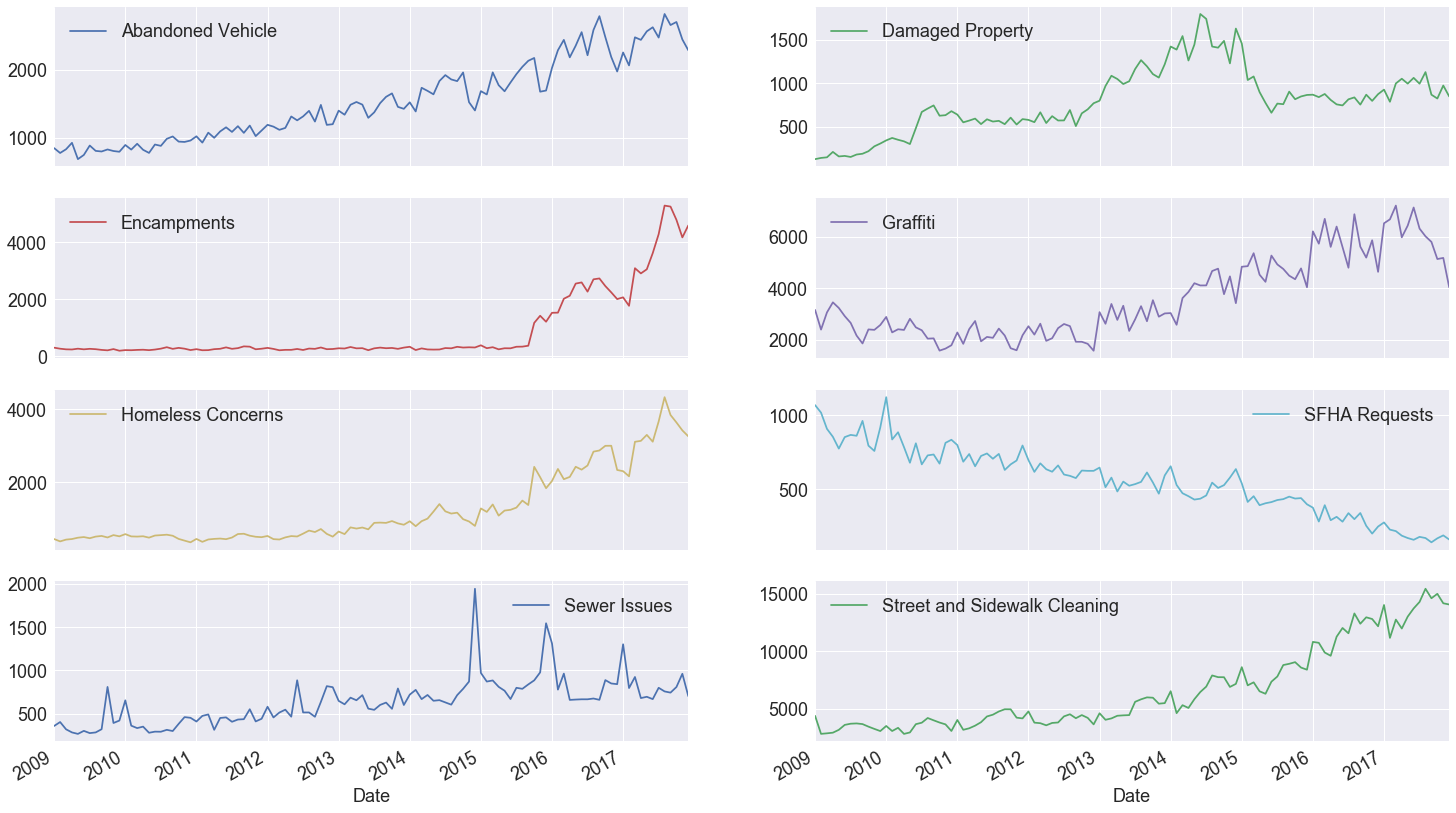

In [11]:
ex2 = ex.copy()
ex2 = pd.get_dummies(ex2['Category'])

ex2.resample('M').sum().plot(subplots=True, figsize=(25, 15), layout=(4, 2), sharey=False)
plt.show()

# Forecast bigger dataset for each request category
## Resampled per month (not week)

In [12]:
d = range(0, 2)
p = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q)) if x[0] + x[1] + x[2] != 0 ]
seasonal_pdq = [(1,0,0,12), (0,1,0,12), (0,0,1,12), (1,1,0,12), (0,1,1,12), (1,1,1,12)]

best_models = {}

Passing over 'Abandoned Vehicle'

Finding the best fit over 108 parameters...   and took 00:00:34.
Best model is ARIMA(0, 1, 2)x(0, 1, 1, 12) with AIC: 867.135

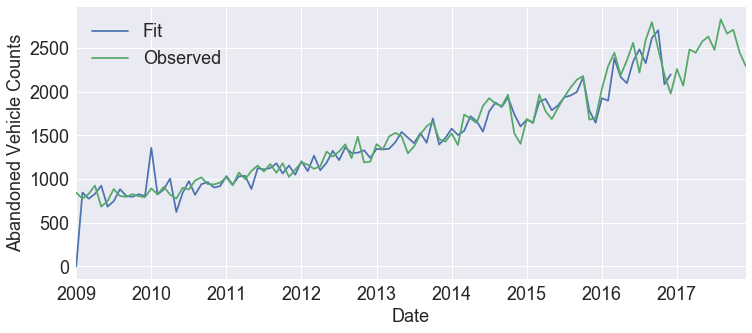

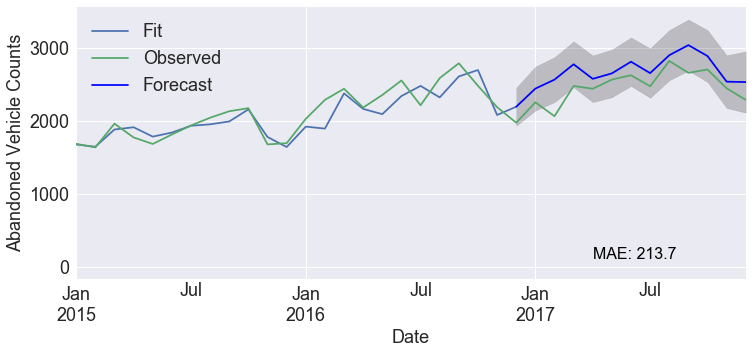

 


Passing over 'Damaged Property'

Finding the best fit over 108 parameters...   and took 00:00:37.
Best model is ARIMA(1, 1, 2)x(0, 1, 1, 12) with AIC: 869.603

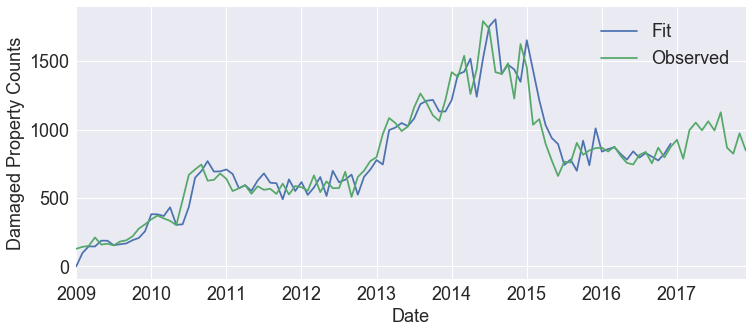

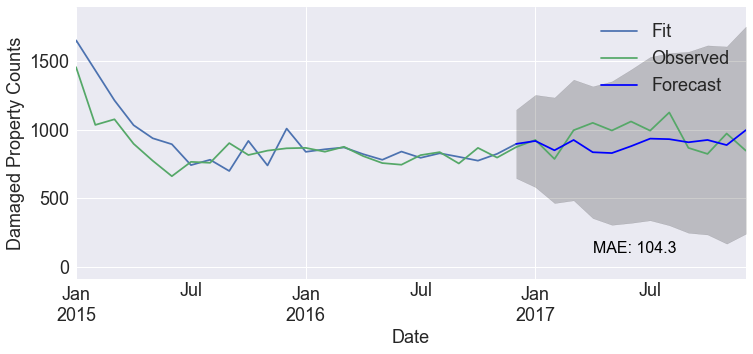

 


Passing over 'Encampments'

Finding the best fit over 108 parameters...   and took 00:00:41.
Best model is ARIMA(2, 1, 2)x(0, 1, 1, 12) with AIC: 895.209

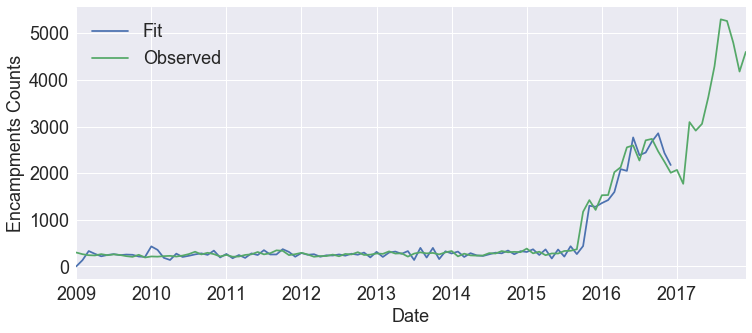

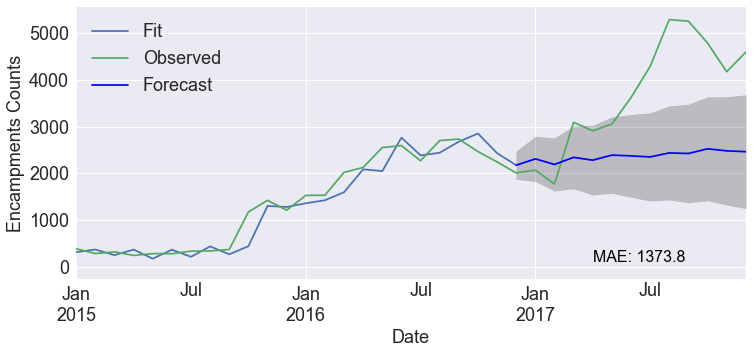

 


Passing over 'Graffiti'

Finding the best fit over 108 parameters...   and took 00:00:33.
Best model is ARIMA(0, 1, 2)x(0, 1, 1, 12) with AIC: 1059.409

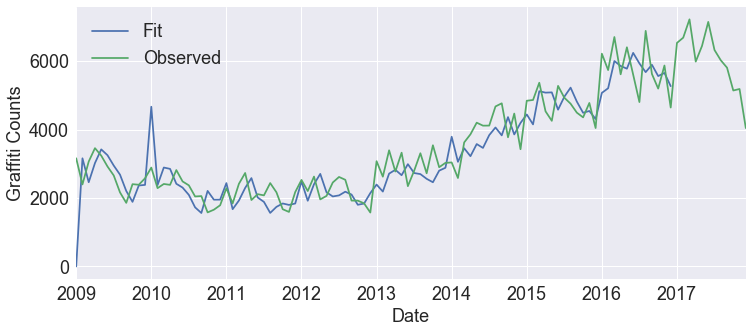

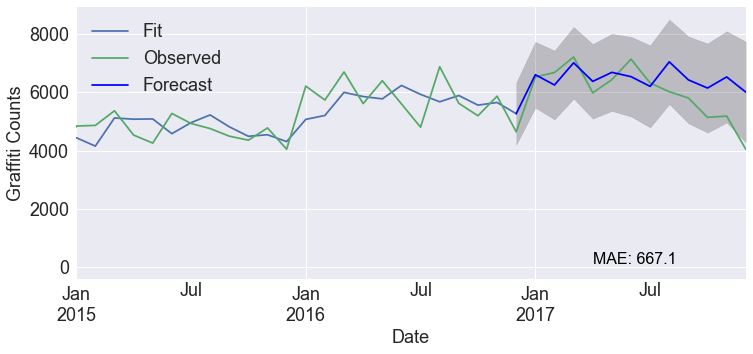

 


Passing over 'Homeless Concerns'

Finding the best fit over 108 parameters...   and took 00:00:37.
Best model is ARIMA(0, 1, 2)x(1, 1, 1, 12) with AIC: 918.618

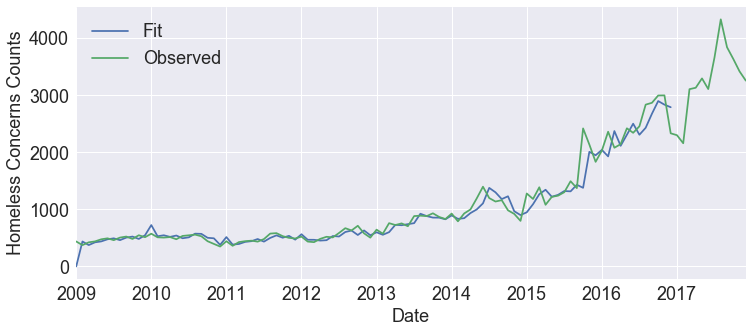

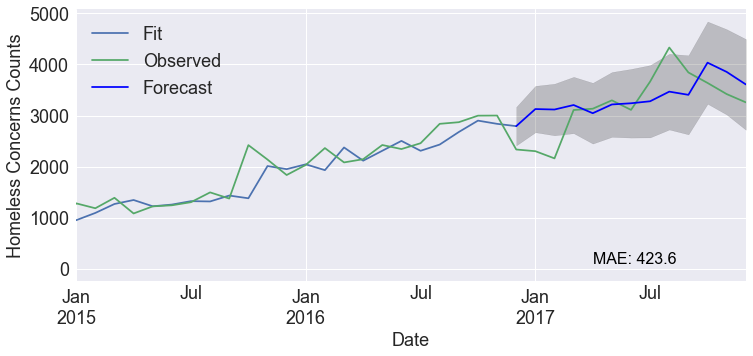

 


Passing over 'SFHA Requests'

Finding the best fit over 108 parameters...   and took 00:00:35.
Best model is ARIMA(0, 1, 2)x(0, 1, 1, 12) with AIC: 751.454

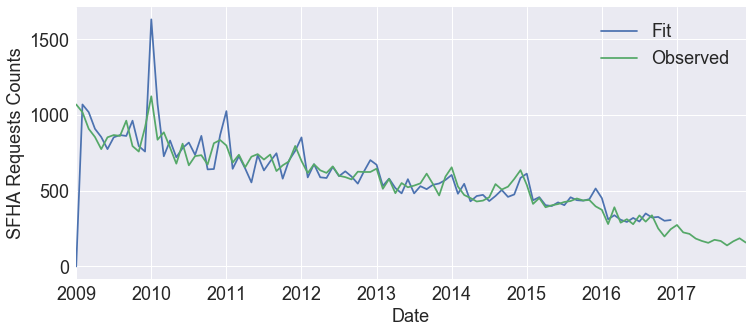

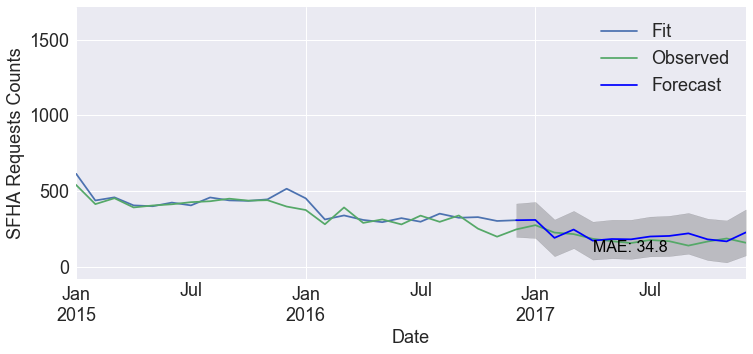

 


Passing over 'Sewer Issues'

Finding the best fit over 108 parameters...   and took 00:00:37.
Best model is ARIMA(0, 1, 2)x(0, 1, 1, 12) with AIC: 922.283

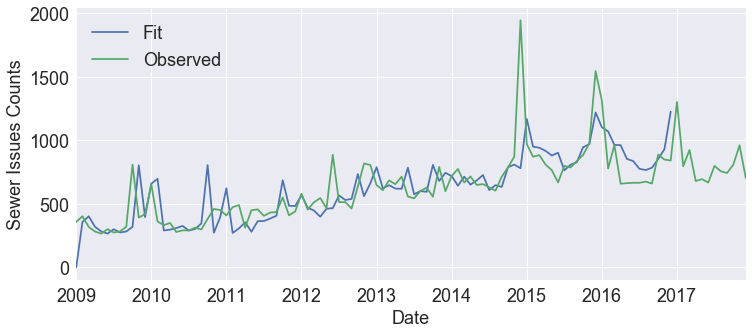

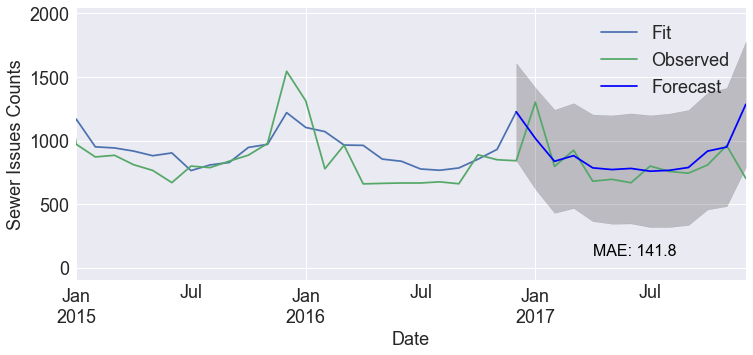

 


Passing over 'Street and Sidewalk Cleaning'

Finding the best fit over 108 parameters...   and took 00:00:33.
Best model is ARIMA(2, 1, 2)x(0, 1, 1, 12) with AIC: 1046.456

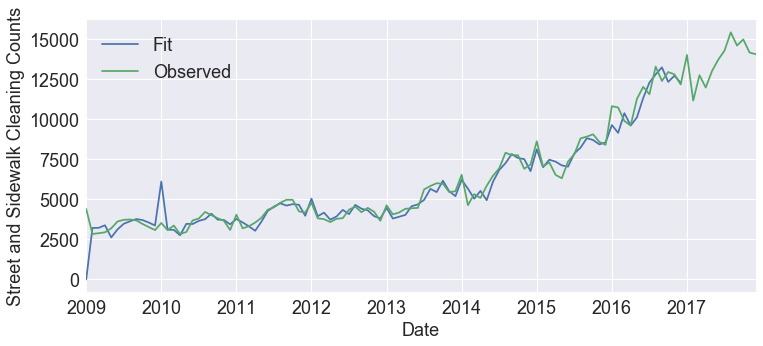

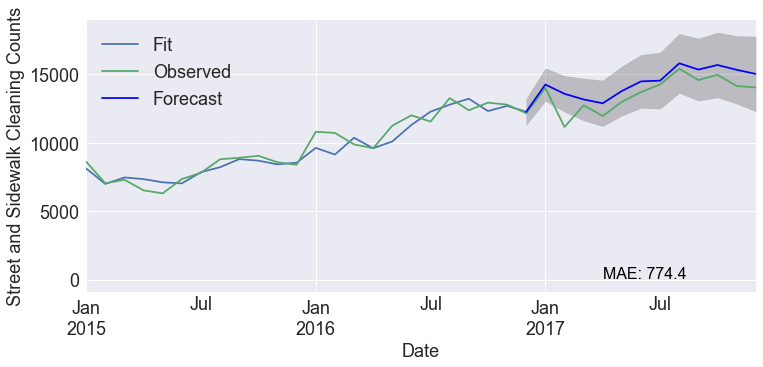

In [13]:
for col in ex2:

    print('Passing over \'%s\'\n%s\n' % (col, '='*40))
        
    time_series = ex2.resample('M').sum()[col]
    x_data = time_series[:-12]
    
    best_param = best_param_seasonal = ()
    best_aic = np.inf

    print 'Finding the best fit over %i parameters... ' % (len(seasonal_pdq)*len(pdq)),
    start = time.time()
    for params in pdq:
        for params_sea in seasonal_pdq:
            try:    
                mod = sm.tsa.statespace.SARIMAX(endog=x_data,
                                                order=params,
                                                seasonal_order=params_sea,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit(disp=False)

                if best_aic > results.aic:
                    best_aic = results.aic
                    best_param = params
                    best_param_seasonal = params_sea
                    
            except:
                continue
                
    #Print out the time it took        
    end = time.time()
    delta = end - start
    print(' and took %02d:%02d:%02d.' % (delta//3600., delta//60., delta%60.))      
    print 'Best model is ARIMA{}x{} with AIC: {:.3f}'.format(best_param, best_param_seasonal, best_aic),
    
    mod = sm.tsa.statespace.SARIMAX(endog=x_data,
                                    order=best_param,
                                    seasonal_order=best_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit(disp=False)
    best_models[col] = mod    
        
    plt.figure(figsize=(12,5))    
    results.fittedvalues.plot(label='Fit')
    time_series.plot(label='Observed')
    plt.xlabel('Date')
    plt.ylabel('%s Counts' % col)
    plt.legend()
    plt.show()               
                    
    #Get the forecast    
    pred = results.get_prediction(start=pd.to_datetime('2016-12-31'), end=pd.to_datetime('2017-12-31'), dynamic=True)
    pred_ci = pred.conf_int()

    mae = mean_absolute_error(pred.predicted_mean, time_series[-13:])
    
    #Plot the forecast with original
    plt.figure(figsize=(12,5))    
    ax = results.fittedvalues.plot(label='Fit')
    time_series.plot(ax=ax, label='Observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast', color='b')

    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('%s Counts' % col)
    plt.text('2017-04-01', 100, 'MAE: %.1f' % mae, fontsize=16, color='k')
    plt.xlim(('2015-01-01','2017-12-31'))
    plt.legend(loc=0)
    plt.show()    
        
    print('\n\n')

## Not too bad of a forecast